<a href="https://colab.research.google.com/github/neel26desai/cmpe255_assignment3/blob/main/KDD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset: https://www.kaggle.com/datasets/jayagopal20/threads-app-reviews-dataset

In [1]:
#mounting drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


#Objective

We have taken the Threads app reviews data, where we have a review and the corresponsing starts assigned to that review. Based on this data we want to create a model which can detect if a give statement in english is positive, negative or neutral.


## Developing and Understanding the Application
We will build a model which takes a text string as an input and will tell if a give statemenet is positive, neutral or negative.
We will also explore the data to make sure we understand if there is any data which we dont want for analysis.
As your data set has 5 values for rating we will encode them such that rating 1 means negativem 2 or 3 or 4 means neutral and 5 means positive

Installing all dependencies needed

In [ ]:
!pip install pycaret

## Creating Target Set
In this stage we combine data from various sources and create the ginal data on which we can perform our analysis.
In our case we only have one file which already contains all the available data.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#importing libraries needed for tokenization of text
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
#importing libraries for automl
from pycaret.classification import ClassificationExperiment

In [4]:
df = pd.read_csv('/content/drive/MyDrive/threads_reviews.csv')

In [5]:
df.head()

,source,review_description,rating,review_date
0,Google Play,Very good app for Android phone and me,5,27-08-2023 10:31
1,Google Play,Sl👍👍👍👍,5,27-08-2023 10:28
2,Google Play,Best app,5,27-08-2023 9:47
3,Google Play,Gatiya app,1,27-08-2023 9:13
4,Google Play,Lit bruv,5,27-08-2023 9:00


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40435 entries, 0 to 40434
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   source              40435 non-null  object
 1   review_description  40435 non-null  object
 2   rating              40435 non-null  int64 
 3   review_date         40435 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [10]:
df.shape

(40435, 4)

In [6]:
# based on our buisness understanding we know that source and review_date wont be every available to our application so there is no point of keeping them
cols_to_drop = ['source','review_date']
df.drop(cols_to_drop,axis=1,inplace=True)

In [12]:
df.head()

,review_description,rating
0,Very good app for Android phone and me,5
1,Sl👍👍👍👍,5
2,Best app,5
3,Gatiya app,1
4,Lit bruv,5


one thing we can tell will cause us problems down the line, is that not all reviews are in the same language. Review 0 is english ,1 is spanish and 3 is hindi. We will handle this in preprcoessing and data cleaning


## Data Cleaning and preprocessing

In [ ]:
#

In [13]:
#now that we have out data set ready let us perform data cleaning and preproceesing

In [15]:
#lets check for any empty values and drop if any
print(df.shape)
print(df.isna().sum().sum())

(40435, 2)
0


We dont have any missing values , now let us filter out our data such that we only are left with all the reviews in english

In [7]:
!pip install langdetect

In [8]:
from langdetect import detect
print(detect("This is an English text."))


en


In [9]:
def is_english(text):
  try:
    return detect(text)=='en'
  except:
    #having this logic to prevent lines with only emojis, causing us problems
    return False


In [11]:
from concurrent.futures import ThreadPoolExecutor

# Using ThreadPoolExecutor to parallelize the function execution
with ThreadPoolExecutor() as executor:
    results = list(executor.map(is_english, df['review_description']))


In [14]:
#let us filter out the dataframes where we have only enlgish reviews
df_english = df[results]

In [15]:
df_english.head()

,review_description,rating
0,Very good app for Android phone and me,5
6,Don't install for privacy concern It's track y...,1
10,Elon from marse,5
11,Poor application,1
14,R to it,5


In [17]:
#lets save the file at this stage to prevent running the computational expensive english detection
df_english.to_csv('/content/drive/MyDrive/english_threads_reviews.csv',index=False)

In [18]:
#reset index
df_english.reset_index(inplace=True)

In [25]:
print(f'After the above filter we are left with {df_english.shape[0]} rows we dropped {df.shape[0]-df_english.shape[0]}')

After the above filter we are left with 27147 rows we dropped 13288


In [19]:
df['rating'].value_counts()

5    18253
1    12921
4     3786
3     3177
2     2298
Name: rating, dtype: int64

Our dataset has ratings as number between 1 and 5, with a greater frequency of 1s and 5s compared to other rating, however we want the it to be either positive,negative or neutral. We will perform an encoding to as part of it.

In [21]:
#performing the encoding as per buisness logic
def custom_encode_sentiment(rating):
    s= set([2,3,4])
    if rating == 5:
        return 'Positive'
    elif rating in s:
        return 'Neutral'
    else:
        return 'Negative'

df_english['custom_sentiment'] = df_english['rating'].apply(custom_encode_sentiment)


In [22]:
df_english.head()

,index,review_description,rating,custom_sentiment
0,0,Very good app for Android phone and me,5,Positive
1,6,Don't install for privacy concern It's track y...,1,Negative
2,10,Elon from marse,5,Positive
3,11,Poor application,1,Negative
4,14,R to it,5,Positive


In [38]:
#at this point we can drop the index and the ratings as they are no longer needed for us
df_english.drop(['index','rating'],axis=1,inplace=True)

<Axes: >

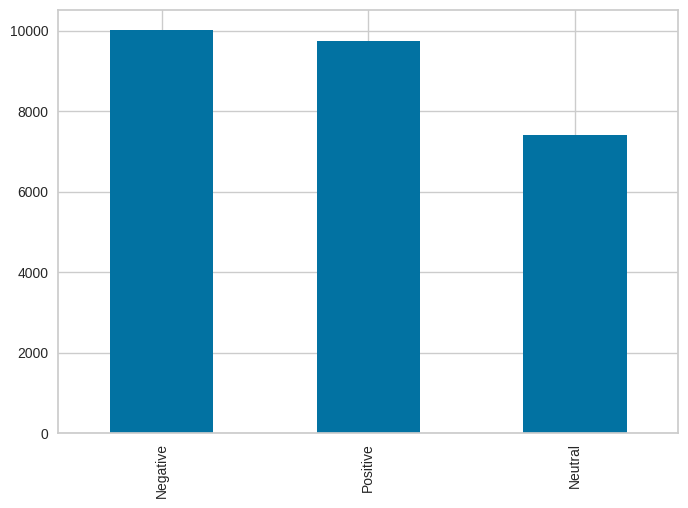

In [39]:
temp=df_english['custom_sentiment'].value_counts()
temp.plot(kind = 'bar')

In [ ]:
# we have more negative values but overall there is much of a bias problem in the data

##Data Transformation

In this step we perform all the required data transformation.
One transformation we require is tokenizing the avialable text data so a model can learn something from it. From this stage instead of

## Choosing Suitable Data Mining task
In our case a multiclass classification works the best for us

##Choosing suitable Data Mining algorithm

In [40]:
exp = ClassificationExperiment()
exp.setup(df_english,target='custom_sentiment',session_id=12)

,Description,Value
0,Session id,12
1,Target,custom_sentiment
2,Target type,Multiclass
3,Target mapping,"Negative: 0, Neutral: 1, Positive: 2"
4,Original data shape,"(27147, 2)"
5,Transformed data shape,"(27147, 2)"
6,Transformed train set shape,"(19002, 2)"
7,Transformed test set shape,"(8145, 2)"
8,Categorical features,1
9,Preprocess,True


In [41]:
#checking out the required preprocessing steps
exp.get_config('pipeline')

Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('label_encoding',
                 TransformerWrapperWithInverse(exclude=None, include=None,
                                               transformer=LabelEncoder())),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None, include=[],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='...
                                                              missing_values=nan,
                                                              strategy='most_frequent',
                                                              verbose='deprecated'))),
                ('rest_encoding',
                 TransformerWrapper(exclude=None,
                                    include=['review_description'],
                                    transformer=TargetEncoder(cols=['review_description'],
                                                              drop_invariant=False,
                                                              handle_missing='return_nan',
                                                              handle_unknown='value',
                                                              hierarchy=None,
                                                              min_samples_leaf=20,
                                                              return_df=True,
                                                              smoothing=10,
                                                              verbose=0)))],
         verbose=False)

## Employing Data mining Algorithm

In [42]:
#let us compare a list baseline models and checkout the best one

In [43]:
baseline_model = exp.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.4178,0.0000,0.4178,0.4557,0.2931,0.0784,0.1848,0.1440
dummy,Dummy Classifier,0.3689,0.5000,0.3689,0.1361,0.1988,0.0000,0.0000,0.1330
svm,SVM - Linear Kernel,0.3657,0.0000,0.3657,0.5904,0.2528,0.0646,0.1611,0.1670
lr,Logistic Regression,0.3361,0.5640,0.3361,0.7204,0.2478,0.0783,0.1774,0.3580
rf,Random Forest Classifier,0.3360,0.5388,0.3360,0.7187,0.2477,0.0781,0.1767,0.9370
ada,Ada Boost Classifier,0.3360,0.5349,0.3360,0.7193,0.2477,0.0781,0.1769,0.4230
gbc,Gradient Boosting Classifier,0.3360,0.5327,0.3360,0.7194,0.2478,0.0782,0.1770,2.4420
lda,Linear Discriminant Analysis,0.3360,0.5639,0.3360,0.7199,0.2477,0.0781,0.1771,0.2710
xgboost,Extreme Gradient Boosting,0.3360,0.5326,0.3360,0.7193,0.2477,0.0781,0.1769,1.6680
lightgbm,Light Gradient Boosting Machine,0.3360,0.5327,0.3360,0.7193,0.2477,0.0781,0.1768,2.1670


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [44]:
#let us see if the model performs well on the test set
exp.predict_model(baseline_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.4174,0,0.4174,0.4486,0.2924,0.0777,0.1820


,review_description,custom_sentiment,prediction_label
5046,Good app but my pics 1 day ago and my pics is ...,1,Negative
15779,Twitter failed,2,Negative
19070,Dear Team. Not sure am I the only one. But in ...,1,Negative
24875,Sure there’s potential (it can’t be that hard ...,0,Negative
3410,I cant post threads on my insta story or feed ...,0,Negative
...,...,...,...
7693,App isnt working properly. It keeps showing gl...,0,Negative
20454,It is famous in Cambodia now 🤣,2,Negative
6432,This app not for intermediate,0,Negative
22973,Good application for Instagramer users,2,Negative


In [45]:
#our models performance is not upto the  mark

## Interpretating mined insights


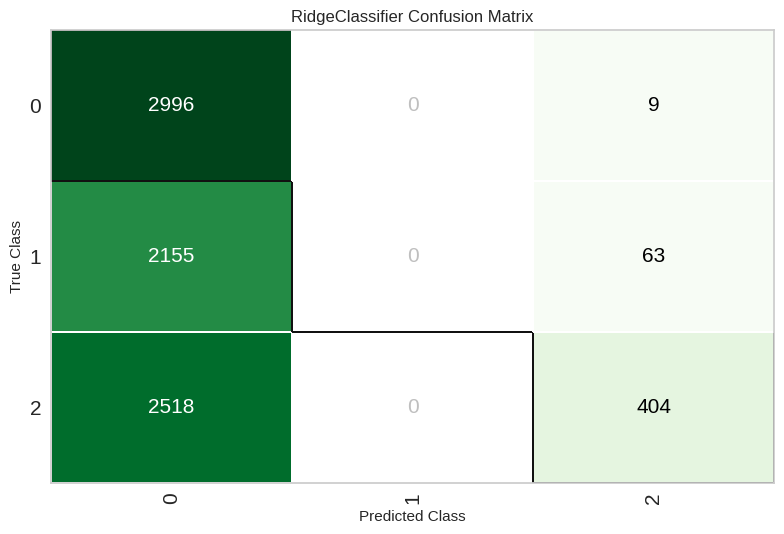

In [47]:
exp.plot_model(baseline_model,plot="confusion_matrix")

Based on the confusion matrix we can tell that our model is very accurate when it comes to predicting negative, and is it not performing well for neutral and positive sentiment

## Using the discovered Knowledge

In [53]:
strs

0          it is alright
1    better than twitter
2       worse one so far
Name: review_description, dtype: object

In [54]:
#lets use this model
strs = pd.DataFrame({'review_description':['it is alright','better than twitter','worse one so far']})

In [55]:
exp.predict_model(baseline_model,strs)

,review_description,prediction_label
0,it is alright,Negative
1,better than twitter,Positive
2,worse one so far,Negative


In [56]:
#the model was able to identify a positive and negative statement correctly, but it failed to identofy the neutal statement